In [1]:
# Import other useful Python packages
import numpy as np
import matplotlib.pyplot as plt
# from importlib import reload
# import warnings
# import copy
# import sys
# import getpass
# current_user = getpass.getuser()
# sys.path.insert(0,'/Users/{0}/documents'.format(current_user))
# import pickle

In [2]:
import spikesorting_fullpursuit as fbp

In [3]:
from spikesorting_fullpursuit.test import gen_dataset 
# from spikesorting_fullpursuit import utils 

In [4]:
from importlib import reload

In [5]:
reload(gen_dataset)

<module 'spikesorting_fullpursuit.test.gen_dataset' from '/Users/Nate/gitprojects/spikesorting_fullpursuit/spikesorting_fullpursuit/test/gen_dataset.py'>

In [6]:
n_chans = 4 # Number of channels to make in test dataset
v_duration = 60 # Test dataset duration in seconds
random_seed = None # Set seed of numpy random number generator for spike times
neuron_templates = None # Just use default pre-loaded template waveforms to generate spike voltage traces
frequency_range = (300, 6000) # Frequencies of dataset in Hz
samples_per_second = 40000 # Sampling rate of 40kHz
amplitude = 1 # Amplitude of 3 standard deviations of noise
percent_shared_noise = .3 # Create shared noise across channels
correlate1_2 = (.10, 10) # Set 15% of neuron 2 spikes to occur within 10 samples of a neuron 1 spike
electrode_type = 'tetrode' # Choose pre-loaded electrode type of tetrode and all channels in neighborhood
voltage_dtype = np.float32 # Create voltage array as float 32

# Create the test dataset object
test_data = gen_dataset.TestDataset(n_chans, v_duration, random_seed, neuron_templates, frequency_range, 
                                    samples_per_second, amplitude, percent_shared_noise,
                                    correlate1_2, electrode_type, voltage_dtype)

In [7]:
# Generate the noise voltage array, without spikes, assigned to test_date.voltage_array
test_data.gen_noise_voltage_array()

In [8]:
# Specify the neurons' properties in the dataset
firing_rates = np.array([90, 100]) # Firing rates
template_inds = np.array([1, 0]) # Templates used for waveforms
chan_scaling_factors = 2*np.array([[1.85, 2.25, 1.65, .5], [3.85, 3.95, 1.95, 3.7]]) # Amplitude of neurons on each of the 4 channels
refractory_win = 1.5e-3 # Set refractory period at 1.5 ms

In [9]:
# Generate the test dataset by choosing spike times and adding them according to the specified properties
test_data.gen_test_dataset(firing_rates, template_inds, chan_scaling_factors, refractory_win)

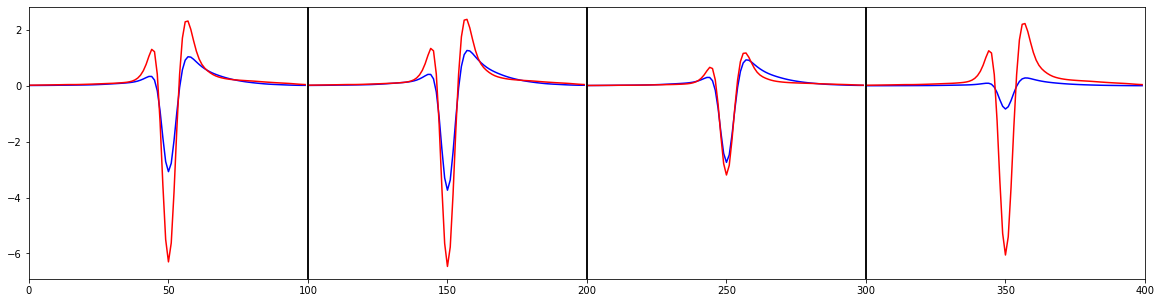

In [10]:
# Plot the two templates used to generate spikes. Templates are concatenated horizontally across channels for plotting.
w_color = ['b', 'r']

# Plot each neuron template
n_neurons = len(test_data.actual_templates)
for n in range(0, n_neurons): 
    use_color = w_color.pop(0)
    
    # Plot template for each channel
    n_template_channels = test_data.actual_templates[n].shape[0]
    n_template_samples = test_data.actual_templates[n].shape[1]
    for chan in range(0, n_template_channels): 
        chan_x_inds = np.arange(n_template_samples*chan, n_template_samples*(chan+1))
        _ = plt.plot(chan_x_inds, test_data.actual_templates[n][chan, :], color=use_color)
        
        # Add vertical lines to delineate channel boundaries for templates
        if chan > 0:
            plt.axvline(n_template_samples*chan, color='k')
ag = plt.gcf()
ag.set_size_inches(20, 5)
_ = plt.xlim([0, n_template_channels*n_template_samples])

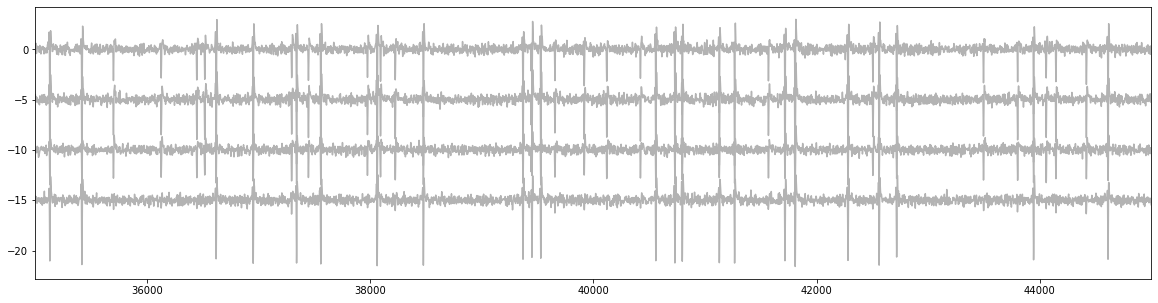

In [11]:
# Plot the synthetic voltage for each channel within the window "v_boundaries" to see that we have successfully added spikes
v_boundaries = [40000 - 5000, 40000 + 5000]
for chan in range(0, test_data.num_channels):
    plt.plot(np.arange(v_boundaries[0], v_boundaries[1]), 
             test_data.Probe.voltage[chan, v_boundaries[0]:v_boundaries[1]] - chan*5, color=[.7, .7, .7])
ag = plt.gcf()
ag.set_size_inches(20, 5)
_ = plt.xlim(v_boundaries)

In [12]:
reload(fbp.test.gen_dataset)
reload(fbp.spikesorting)
reload(fbp.segment)
reload(fbp.parallel.spikesorting_parallel)
reload(fbp.parallel.segment_parallel)
reload(fbp.sort)
reload(fbp.consolidate)
reload(fbp.preprocessing)
reload(fbp.binary_pursuit)
reload(fbp.parallel.binary_pursuit_parallel)
reload(fbp.full_binary_pursuit)
reload(fbp.neuron_separability)
reload(fbp.utils.parallel_funs)

<module 'spikesorting_fullpursuit.utils.parallel_funs' from '/Users/Nate/gitprojects/spikesorting_fullpursuit/spikesorting_fullpursuit/utils/parallel_funs.py'>

In [ ]:
# Run the sorting algorithm on the synthetically generated dataset.

# Some of the possible input variables extracted to play with
sigma = 4.0 # Sigma for detecting events/spike clips
clip_width = [-8e-4, 8e-4] # Spike clip width used for finding templates (in ms)
check_components = 20 # Number of PCs to check when searching for best PCs to use
max_components = 5 # Maximum number of PCs to use for clustering
p_value_cut_thresh = .01 # P-value used to determine whether to split clusters in iso-cut algorithm
sigma_bp_noise = 2.326 # Threshold for adding spikes in binary pursuit relative to expected noise variance
log_dir = None # You can optionally enter a directory string where more detailed text about the sorting progress and errors will be printed.

# Resets random seed to the one last used so that results are repeatable
np.random.set_state(test_data.random_state)

# Enter the remaining variables for clarity. Run sorter and get outputs.
sort_data, work_items, sort_info = test_data.sort_test_dataset_parallel({'p_value_cut_thresh': p_value_cut_thresh, 'sigma': sigma,
                                       'clip_width': clip_width, 'check_components': check_components, 
                                       'max_components': max_components, 'verbose': True, 'do_ZCA_transform': True,
                                       'min_firing_rate': 0.1, 'add_peak_valley': False,
                                       'do_branch_PCA': True, 'max_gpu_memory': .1 * (1024 * 1024 * 1024),
                                       'use_rand_init': True, 'segment_duration': 600, 'segment_overlap': 30, 
                                       'test_flag': False, 'log_dir': log_dir, 'do_branch_PCA_by_chan': True, 'sort_peak_clips_only': True,
                                        'get_adjusted_clips': False,
                                        'n_cov_samples': 20000,
                                        'sigma_bp_noise': 2.326, 'sigma_bp_CI': 12.0, 
                                        'max_binary_pursuit_clip_width_factor': 2.,
                                        'do_overlap_recheck': True})

Using  1 segments per channel for sorting.
Doing parallel ZCA transform and thresholding for 1 segments
No log dir specified. Won't be able to see output from processes
Starting sorting pool
Starting item 1/4 on CPUs [0] for channel 1 segment 0
Starting item 2/4 on CPUs [1] for channel 0 segment 0
Starting item 3/4 on CPUs [2] for channel 3 segment 0
Starting item 4/4 on CPUs [3] for channel 2 segment 0
Identifying threshold crossings
Identifying threshold crossings
Using minimum cluster size of 6
Identifying threshold crossings
Using minimum cluster size of 6
Using minimum cluster size of 6
Identifying threshold crossings
Using minimum cluster size of 6
After keep max on main removed 5390 clips
Start initial clustering and merge
After keep max on main removed 2436 clips
Start initial clustering and merge
After keep max on main removed 8768 clips
Start initial clustering and merge
After first sort 1 different clusters
After keep max on main removed 10525 clips
Start initial clustering 

/Users/Nate/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Nate/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/Nate/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/Nate/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Nate/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/Nate/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: Ru

After re-sort 2 different clusters
Currently 2 different clusters
After first sort 2 different clusters
After SINGLE BRANCH 2 different clusters
After MULTI BRANCH 2 different clusters
After MULTI BRANCH by channel 2 different clusters
Current smallest cluster has 87 spikes
currently 2 different clusters
Successfully completed item  1
Completed item 2 from chan 0 segment 0
Exited with status:  Success
After re-sort 3 different clusters
Currently 3 different clusters
After SINGLE BRANCH 3 different clusters
After MULTI BRANCH 7 different clusters
After MULTI BRANCH by channel 7 different clusters
Current smallest cluster has 47 spikes
currently 7 different clusters
Successfully completed item  0
Completed item 1 from chan 1 segment 0
Exited with status:  Success
!!!!!!USING ACTUAL NEIGHBORS LINE 127 FULL BINARY PURSUIT
Entered with 11 templates in segment 0
Binary pursuit clip width is [-0.001525, 0.0016] from [-0.0008, 0.0008]
Binary pursuit samples per chan 126 from 65
Computing clip 

In [14]:
reload(fbp.consolidate)
reload(fbp.neuron_separability)

<module 'spikesorting_fullpursuit.neuron_separability' from '/Users/Nate/gitprojects/spikesorting_fullpursuit/spikesorting_fullpursuit/neuron_separability.py'>

In [15]:
# First step in automated post-processing
# Set a few variables that can allow easy detection of units that are poor
absolute_refractory_period = 10e-4 # Refractory period (in ms) will be used to determine potential violations in sorting accuracy
# Max allowable ratio between refractory period violations and maximal bin of ACG. Units that violate will be deleted. Setting to 1. allows all units
max_mua_ratio = 1. 
min_snr = 0 # Minimal SNR a unit must have to be included in post-processing
min_overlapping_spikes = .75 # Percentage of spikes required with nearly identical spike times in adjacent segments for them to combine in stitching

# Create the work_summary postprocessing object
work_summary = fbp.postprocessing.WorkItemSummary(sort_data, work_items, sort_info, 
                                           absolute_refractory_period=absolute_refractory_period, max_mua_ratio=max_mua_ratio,
                                           min_snr=min_snr, min_overlapping_spikes=min_overlapping_spikes, 
                                           verbose=False)

No overlap between segments found. Switching stitch_overlap_only to False.
Least MUA removed was inf on channel None segment None
Maximum SNR removed was -inf on channel None segment None


In [16]:
# No segments in the example (segment_duration > duration of synthetic data) but done as example
work_summary.stitch_segments()

Start stitching channel 0
Start stitching channel 1
Start stitching channel 2
Start stitching channel 3


In [17]:
# Summarize the sorted output data into dictionaries by time segment. 
work_summary.summarize_neurons_by_seg()

In [18]:
# Finally summarize neurons across channels (combining and removing duplicate neurons across space) to get a list of sorted "neurons"
neurons = work_summary.summarize_neurons_across_channels(overlap_ratio_threshold=np.inf, min_segs_per_unit=1)

Redundant neurons already removed at threshold >= inf Further attempts will have no effect.
Skipping remove_redundant_neurons_by_seg.


In [19]:
fmtL = "Unit: {:.0f} on chans {}; n spikes = {:.0f}; FR = {:.0f}; Dur = {:.0f}; SNR = {:.2f}; MUA = {:.2f}; TolInds = {:.0f}"
for ind, n in enumerate(neurons):
    print_vals = [ind, n['channel'], n['spike_indices'].size, n['firing_rate'], n['duration_s'], n['snr']['average'], n['fraction_mua'], n['duplicate_tol_inds']]
    print(fmtL.format(*print_vals))

Unit: 0 on chans [1]; n spikes = 5454; FR = 91; Dur = 60; SNR = 4.98; MUA = 0.00; TolInds = 9
Unit: 1 on chans [1]; n spikes = 5529; FR = 92; Dur = 60; SNR = 8.67; MUA = 0.00; TolInds = 8
Unit: 2 on chans [3]; n spikes = 460; FR = 8; Dur = 60; SNR = 8.51; MUA = 0.00; TolInds = 7


5529 channel = [1]


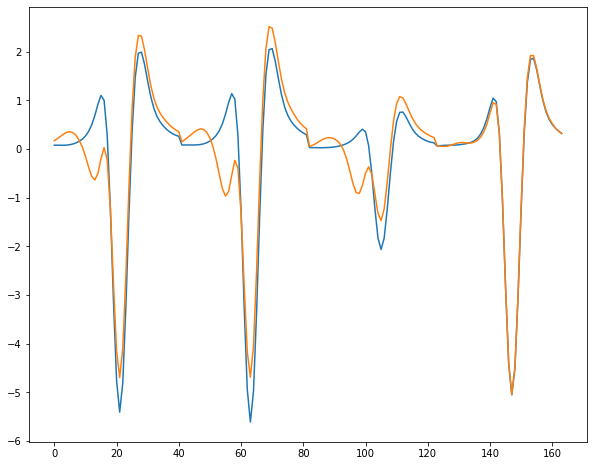

In [29]:
num_neuron = 1
num_1, num_2 = num_neuron, num_neuron
num_2 = 2
print(neurons[num_neuron]['spike_indices'].size, "channel =", neurons[num_neuron]['channel'])
for chan in neurons[num_1]['channel']:
    plt.plot(neurons[num_1]['template'][chan][0:])
for chan in neurons[num_2]['channel']:
    plt.plot(neurons[num_2]['template'][chan][0:])
# plt.plot(sort_info['separability_metrics'][0]['templates'][0, :])
# plt.plot(sort_info['separability_metrics'][0]['templates'][1, :])
ag = plt.gcf()
ag.set_size_inches(10, 8)

In [21]:
# Find best match for neuron num_1
test_match1 = None
max_true_positives1 = 0
test_match2 = None
max_true_positives2 = 0
for test_num in range(0, len(test_data.actual_IDs)):
    overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_1]['spike_indices'], overlap_tol=10)
    true_positives = np.count_nonzero(overlapping_spike_bool)
    if true_positives > max_true_positives1:
        max_true_positives1 = true_positives
        test_match1 = test_num
    overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_2]['spike_indices'], overlap_tol=10)
    true_positives = np.count_nonzero(overlapping_spike_bool)
    if true_positives > max_true_positives2:
        max_true_positives2 = true_positives
        test_match2 = test_num
print("Matched unit", num_1, "to actual unit", test_match1)
print("Matched unit", num_2, "to actual unit", test_match2)


Matched unit 1 to actual unit 1
Matched unit 2 to actual unit 1


In [22]:
tol_inds = 20
spikes2act_in1 = fbp.analyze_spike_timing.find_overlapping_spike_bool(neurons[num_1]['spike_indices'], test_data.actual_IDs[test_match2], overlap_tol=tol_inds)
spikes2sort_in1 = fbp.analyze_spike_timing.find_overlapping_spike_bool(neurons[num_1]['spike_indices'], neurons[num_2]['spike_indices'], overlap_tol=tol_inds)
spikes1_from2 = np.count_nonzero(np.logical_and(spikes2act_in1, ~spikes2sort_in1))
print("p a spike from unit", num_2, "was assigned to unit", num_1, ":", spikes1_from2/neurons[num_2]['spike_indices'].shape[0])

spikes1act_in2 = fbp.analyze_spike_timing.find_overlapping_spike_bool(neurons[num_2]['spike_indices'], test_data.actual_IDs[test_match1], overlap_tol=tol_inds)
spikes1sort_in2 = fbp.analyze_spike_timing.find_overlapping_spike_bool(neurons[num_2]['spike_indices'], neurons[num_1]['spike_indices'], overlap_tol=tol_inds)
spikes2_from1 = np.count_nonzero(np.logical_and(spikes1act_in2, ~spikes1sort_in2))
print("p a spike from unit", num_1, "was assigned to unit", num_2, ":", spikes2_from1/neurons[num_1]['spike_indices'].shape[0])

p a spike from unit 2 was assigned to unit 1 : 12.019565217391305
p a spike from unit 1 was assigned to unit 2 : 0.08319768493398444


In [23]:
sep_mat, noise_cont, noise_miss = fbp.neuron_separability.pairwise_separability(sort_info['separability_metrics'][0], sort_info)
sep_mat, noise_cont, noise_miss

(array([[0.00000000e+00, 6.43909152e-39, 5.27213676e-40, 8.65501154e-24],
        [1.85783184e-40, 0.00000000e+00, 7.95515745e-03, 8.13391113e-91],
        [6.74303908e-11, 3.30005655e-01, 0.00000000e+00, 4.46756606e-15],
        [4.11863545e-03, 2.74752260e-10, 1.03814363e-10, 0.00000000e+00]]),
 array([2.17919311e-025, 3.70853423e-186, 5.10208941e-011, 1.00000000e+000]),
 array([4.95221634e-28, 1.77648211e-33, 9.77900471e-15, 5.29072188e-01]))

In [24]:
num_neuron = 0
test_num = 1
tol_inds = 10
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_neuron]['spike_indices'], overlap_tol=tol_inds)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[num_neuron]['spike_indices'].size - true_positives) / neurons[num_neuron]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[test_num].size)
print("Spike inds go from", neurons[num_neuron]['spike_indices'][0], "to", neurons[num_neuron]['spike_indices'][-1])

False discoveries are 85.7902456912358
True positives are 12.94039071631324
Spike inds go from 575 to 2399424


In [25]:
num_neuron = 1
test_num = 0
tol_inds = 10
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_neuron]['spike_indices'], overlap_tol=tol_inds)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[num_neuron]['spike_indices'].size - true_positives) / neurons[num_neuron]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[test_num].size)
print("Spike inds go from", neurons[num_neuron]['spike_indices'][0], "to", neurons[num_neuron]['spike_indices'][-1])

False discoveries are 91.77066377283414
True positives are 8.336386954928546
Spike inds go from 1126 to 2399495


In [26]:
num_neuron = 0
test_num = 0
tol_inds = 10
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_neuron]['spike_indices'], overlap_tol=tol_inds)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[num_neuron]['spike_indices'].size - true_positives) / neurons[num_neuron]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[test_num].size)
print("Spike inds go from", neurons[num_neuron]['spike_indices'][0], "to", neurons[num_neuron]['spike_indices'][-1])

False discoveries are 0.0
True positives are 99.92671308171491
Spike inds go from 575 to 2399424


In [27]:
num_neuron = 1
test_num = 1
tol_inds = 10
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_neuron]['spike_indices'], overlap_tol=tol_inds)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[num_neuron]['spike_indices'].size - true_positives) / neurons[num_neuron]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[test_num].size)
print("Spike inds go from", neurons[num_neuron]['spike_indices'][0], "to", neurons[num_neuron]['spike_indices'][-1])

False discoveries are 0.0
True positives are 92.3192519619302
Spike inds go from 1126 to 2399495


In [106]:
num_neuron = 2
test_num = 2
tol_inds = 10
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_neuron]['spike_indices'], overlap_tol=tol_inds)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[num_neuron]['spike_indices'].size - true_positives) / neurons[num_neuron]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[test_num].size)
print("Spike inds go from", neurons[num_neuron]['spike_indices'][0], "to", neurons[num_neuron]['spike_indices'][-1])

IndexError: list index out of range

In [41]:
num_neuron = 2
test_num = 2
tol_inds = 10
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_neuron]['spike_indices'], overlap_tol=tol_inds)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[num_neuron]['spike_indices'].size - true_positives) / neurons[num_neuron]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[test_num].size)
print("Spike inds go from", neurons[num_neuron]['spike_indices'][0], "to", neurons[num_neuron]['spike_indices'][-1])

False discoveries are 0.0
True positives are 99.35483870967742
Spike inds go from 665 to 4799658


In [165]:
np.count_nonzero(overlapping_spike_bool)

4805

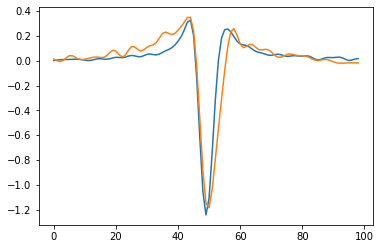

In [462]:
plt.plot(np.mean(neurons[num_neuron]['clips'][overlapping_spike_bool], axis=0))
plt.plot(np.mean(neurons[num_neuron]['clips'][~overlapping_spike_bool], axis=0))

In [463]:
# plt.plot(neurons[num_neuron]['clips'][overlapping_spike_bool].T)

In [464]:
test_data.actual_IDs[0].shape

(4237,)

In [465]:
test_num = 0
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_neuron]['spike_indices'], overlap_tol=40)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[num_neuron]['spike_indices'].size - true_positives) / neurons[num_neuron]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[test_num].size)
print("Spike inds go from", neurons[num_neuron]['spike_indices'][0], "to", neurons[num_neuron]['spike_indices'][-1])

False discoveries are 6.286836935166994
True positives are 90.06372433325465
Spike inds go from 229 to 2399239


In [1048]:
test_num = 2
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], neurons[num_neuron]['spike_indices'], overlap_tol=10)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[num_neuron]['spike_indices'].size - true_positives) / neurons[num_neuron]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[test_num].size)
print("Spike inds go from", neurons[num_neuron]['spike_indices'][0], "to", neurons[num_neuron]['spike_indices'][-1])

IndexError: list index out of range

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
saved_voltage = np.load("/Users/Nate/test_voltage.npy")

In [19]:
saved_voltage.shape

(4, 2400000)

In [20]:
from spikesorting_fullpursuit import electrode
reload(electrode)

<module 'spikesorting_fullpursuit.electrode' from '/Users/Nate/gitprojects/spikesorting_fullpursuit/spikesorting_fullpursuit/electrode.py'>

In [21]:
Probe = electrode.SingleTetrode(40000, saved_voltage)

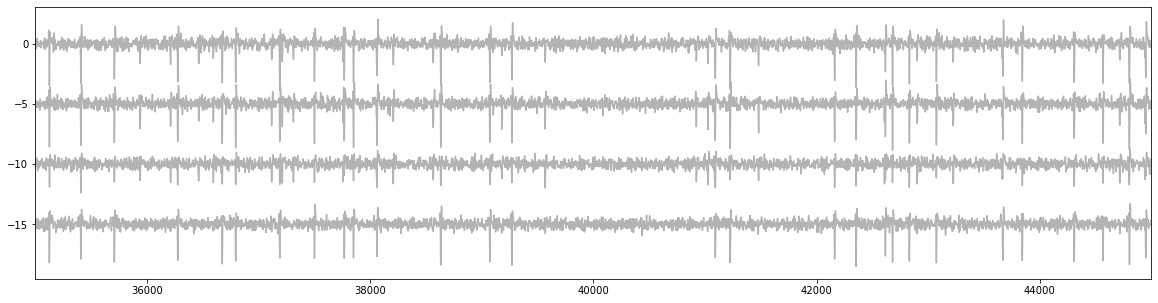

In [22]:
# Plot the synthetic voltage for each channel within the window "v_boundaries" to see that we have successfully added spikes
v_boundaries = [40000 - 5000, 40000 + 5000]
for chan in range(0, saved_voltage.shape[0]):
    plt.plot(np.arange(v_boundaries[0], v_boundaries[1]), 
             Probe.voltage[chan, v_boundaries[0]:v_boundaries[1]] - chan*5, color=[.7, .7, .7])
ag = plt.gcf()
ag.set_size_inches(20, 5)
_ = plt.xlim(v_boundaries)

In [23]:
Probe.bandpass_filter_parallel(300, 600)

Allocating filter array and copying voltage
Performing voltage filtering


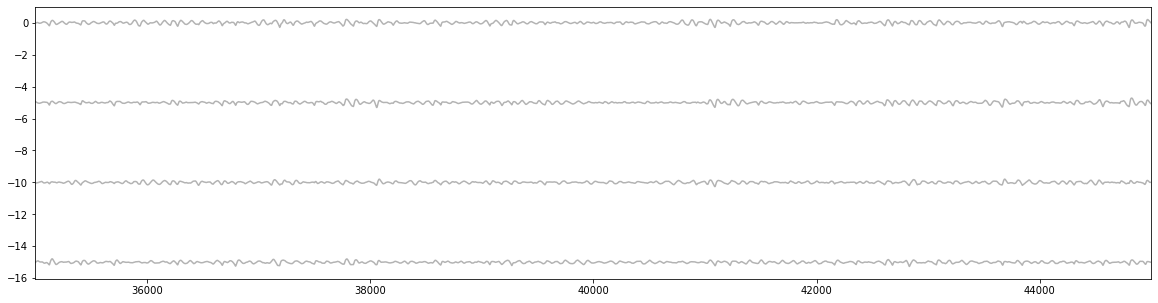

In [24]:
# Plot the synthetic voltage for each channel within the window "v_boundaries" to see that we have successfully added spikes
v_boundaries = [40000 - 5000, 40000 + 5000]
for chan in range(0, saved_voltage.shape[0]):
    plt.plot(np.arange(v_boundaries[0], v_boundaries[1]), 
             Probe.voltage[chan, v_boundaries[0]:v_boundaries[1]] - chan*5, color=[.7, .7, .7])
ag = plt.gcf()
ag.set_size_inches(20, 5)
_ = plt.xlim(v_boundaries)

In [20]:
saved_voltage = filter_parallel(Probe, 300, 600)

Allocating filter array and copying voltage
Performing voltage filtering


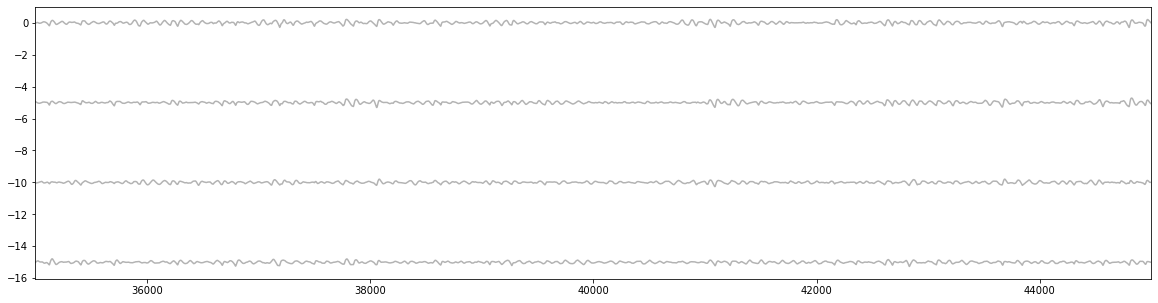

In [21]:
# Plot the synthetic voltage for each channel within the window "v_boundaries" to see that we have successfully added spikes
v_boundaries = [40000 - 5000, 40000 + 5000]
for chan in range(0, saved_voltage.shape[0]):
    plt.plot(np.arange(v_boundaries[0], v_boundaries[1]), 
             saved_voltage[chan, v_boundaries[0]:v_boundaries[1]] - chan*5, color=[.7, .7, .7])
ag = plt.gcf()
ag.set_size_inches(20, 5)
_ = plt.xlim(v_boundaries)

In [14]:
import os.path

In [15]:
os.path.isfile("/users/nate/test_voltage.npy")

True

In [18]:
"/users/nate/".rstrip("/")

'/users/nate'